In [1]:
import pytensor
import pytensor.tensor as pt

from pytensor.compile.mode import get_default_mode

## Differentiating loops

Let's write a trivial numerical loop

In [2]:
x0 = 0.95
x = x0
for i in range(4):
    x = x ** 2
x4 = x
x4

0.44012666865176564

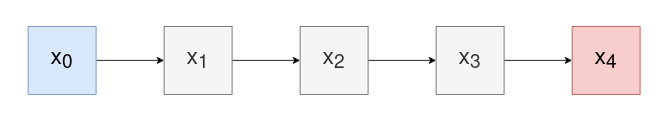

*Blue squares denote inputs, red outputs, and white, intermediate quantities*

How does the final x4 change if we perturb ever so slightly x0. In other words, what is the derivative of the x4 with respect to x0?

Analytically, this function is equivalent to `x4 = x0 ** 2 ** 4 == x0 ** 16`, so the derivative is `16 * (x0 ** 15)`

In [3]:
x0 ** 16

0.44012666865176536

In [4]:
16 * x0 ** 15

7.412659682556049

But we're interested in automatic differentiation, not symbolic differentiation. We want an algorithm that works regardless of the update expression in each step of the loop.

And in particular we want to perform reverse-mode automatic differentiation, which is the most used format for machine learning.

To get some intuition, we can unroll the loop and differentiate each step in reverse, accumulating the partial derivatives at each step. This is a generic application of the chain rule.

In [5]:
x1 = x0 ** 2
x2 = x1 ** 2
x3 = x2 ** 2
x4 = x3 ** 2

In [6]:
dout_dx4 = 1.0  # They're the same
dout_dx3 = dout_dx4 * 2 * x3
dout_dx2 = dout_dx3 * 2 * x2
dout_dx1 = dout_dx2 * 2 * x1
dout_dx0 = dout_dx1 * 2 * x0
dout_dx0

7.412659682556052

The general pattern is to differentiate the step function `x ** 2` and multiply (or dot in the case of multivariate gradients) with the gradient from the "future" step.

Note that we reused the intermediate steps of the original loop. This is usually the case, so it may be useful if our looping constructs can store these results for the gradient calculation. Programmatically, our approach to differentiate this kind of loop looks something like:

In [7]:
xtm1 = pt.scalar("xtm1")
xt = xtm1 ** 2

dout_dxt = pt.scalar("dout_dxt")
dout_dxtm1 = pytensor.gradient.Lop(xt, wrt=xtm1, eval_points=dout_dxt)

step_fn = pytensor.function([xtm1], xt)
d_step_fn = pytensor.function([xtm1, dout_dxt], dout_dxtm1)

In [8]:
xs = [x0]
for i in range(4):
    xs.append(float(step_fn(xs[-1])))
xs

[0.95, 0.9025, 0.81450625, 0.6634204312890625, 0.44012666865176564]

In [9]:
dout_dx4 = 1.0  # They are the same
dout_dxt = dout_dx4
for i in reversed(range(4)):
    dout_dxt = float(d_step_fn(xs[i], dout_dxt))
dout_dx0 = dout_dxt
dout_dx0

7.412659682556052

Unsurprisingly, to differentiate a loop operation we just need another loop operation. If we are clever about how we represent it, we can reuse our regular automatic-differentiation machinery...

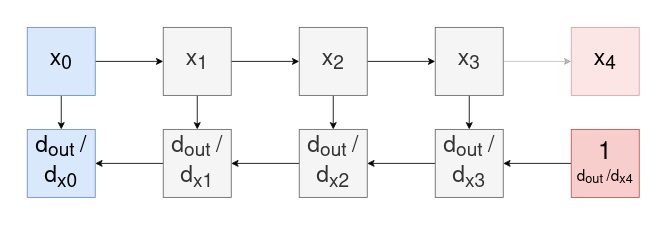

*Blue squares denote inputs or gradient with respect to inputs, red squares outputs or output gradients, and white squares denote intermediate quantities. Washed out squares indicate variables not needed for the final computation*

This approach works, but it introduces a new loop structure. The original loop's state `x` depended only on its previous state `xtm1`. The gradient loop's state `dout_dxt` depends on both its previous state `dout_dxtm1` and an external sequence `xs[i]`.

This difference becomes important for higher-order derivatives. If we differentiate this gradient loop again (for the second derivative), our differentiation machinery must handle loops that read from an external sequence.

Our step function looks like `dout_dxt = 2 * xs[i] * dout_dxtm1`.

The chain rule doesn't care about the semantics of the input variables, so let's rename them and focus on the essentials:
- `z` for the loop state (the accumulating gradient, `dout_dxt`).
- `y` for the input sequence (`xs`).

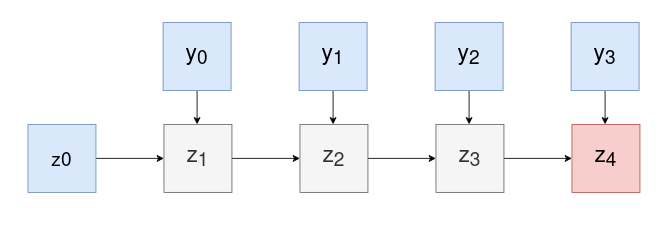

Each step is a function of two variables, of the form `zt = 2 * y[tm1] * ztm1`

Because we are applying the chain rule, we don't have to know anything about the relationship between each `y`. They are just a sequence of inputs to this specific loop. Accordingly, we draw no arrows between them in the diagram.

To stay general, we need a way to compute the partial derivatives of the loop outcome with respect to each intermediate `y[tm1]`. Let's give it a more general name: `dout_dyt`.

We can use the same strategy and reason about the unrolled loop (using our new abstract variable names)

In [10]:
y = xs[:-1][::-1]

z0 = 1.0
z1 = 2 * y[0] * z0
z2 = 2 * y[1] * z1
z3 = 2 * y[2] * z2
z4 = 2 * y[3] * z3
zT = z4
zT

7.412659682556052

We need two quantities. First, the gradient of each intermediate step with respect to the sequence value read on that step.

`zt = 2 * y[tm1] * ztm1`

`dzt/dy[t] = 2 * ztm1`

Again note that we can (and probably want to) reuse the intermediate steps `zt` from the loop we're differentiating. This is a common motif.

In [11]:
dz4_dy3 = 2 * z3
dz3_dy2 = 2 * z2
dz2_dy1 = 2 * z1
dz1_dy0 = 2 * z0

And second, we need the the gradient of each step with respect to the previous step

`dzt/dztm1 = 2 * y[tm1]`

In [12]:
dout_dz4 = 1.0  # They're the same
dz4_dz3 = 2 * y[3]
dz3_dz2 = 2 * y[2]
dz2_dz1 = 2 * y[1]
dz1_dz0 = 2 * y[0]

By the chain rule, the gradient of the final `z` with respect to each indexed sequence is `dout_dyt = dout_dzt * dzt_dyt`.

In the snippet below we don't accumulate the gradient `dout_dzt` to emphasize how this quantity is generated recursively. This is clearly wasteful!

In [13]:
dout_dy3 = dout_dz4 * dz4_dy3
dout_dy2 = dout_dz4 * dz4_dz3 * dz3_dy2
dout_dy1 = dout_dz4 * dz4_dz3 * dz3_dz2 * dz2_dy1
dout_dy0 = dout_dz4 * dz4_dz3 * dz3_dz2 * dz2_dz1 * dz1_dy0
(dout_dy3, dout_dy2, dout_dy1, dout_dy0)

(7.802799665848476, 8.21347333247208, 9.100801476423358, 11.1733967375)

This partial derivative is less intuitive to verify analytically, so we'll compare with finite differences.

In [14]:
# Wrap the gradient loop in a function
def foreach_loop(x0, ys):
    x = x0
    for y in ys:
        x = 2 * x * y
    return x

# Confirm we get the same results
ys = xs[:-1][::-1]

foreach_loop(1.0, ys)

7.412659682556052

In [15]:
# Perform finite differences on each y[t]
def finite_differences(ys, t, eps=1e-5):
    ysp, ysm = ys.copy(), ys.copy()
    ysp[t] += eps
    ysm[t] -= eps
    rp = foreach_loop(1.0, ysp)
    rm = foreach_loop(1.0, ysm)
    return (rp - rm) / (2 * eps)

[finite_differences(ys, idx) for idx in reversed(range(4))]

[7.802799665812542, 8.213473332396859, 9.100801476336073, 11.173396737396144]

The results match.

With the risk of over-doing it, here is the graphical representation of our new reverse-mode autodiff loop. Note we generate two quantities as we iterate: the gradient with respect to each sequence and the previous state.

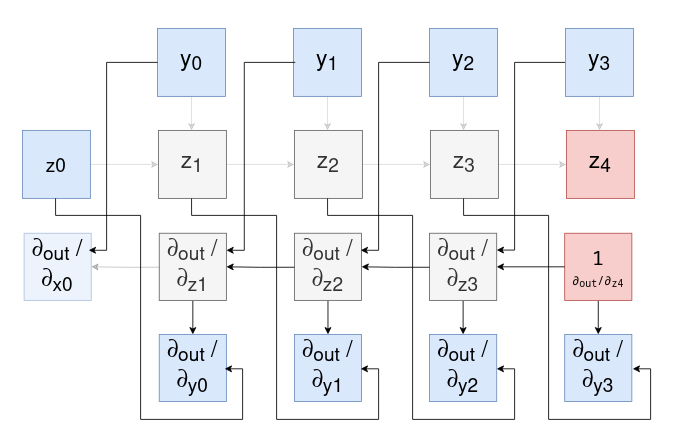

Let's recall what our abstract variable names mean for our example:

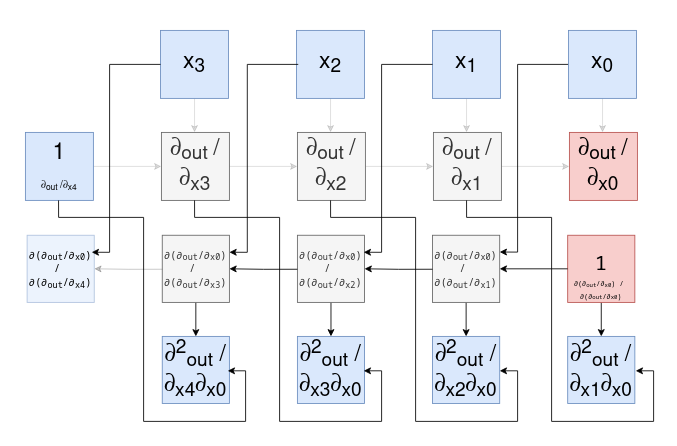

This gives us the partial second derivatives with respect to each intermediate step of the original forward loop (the fourth row of boxes). We now need to propagate them back to the initial point x0.

This is also something slightly new. We have differentiated the final state of a loop with respect to the starting state, and we have differentiated the final state of a loop with respect to a sequence of values **consumed** in a loop. Now we need to differentiate a sequence of values **produced** in a loop with respect to the initial state.

Let's look back at our first gradient loop scheme:

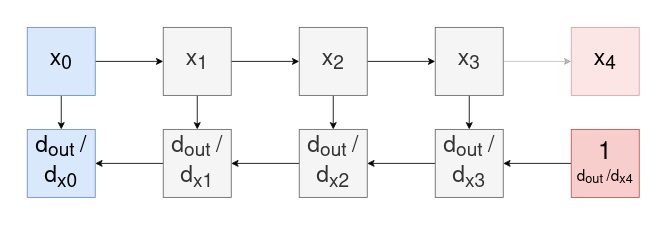

We can re-express it as follows:

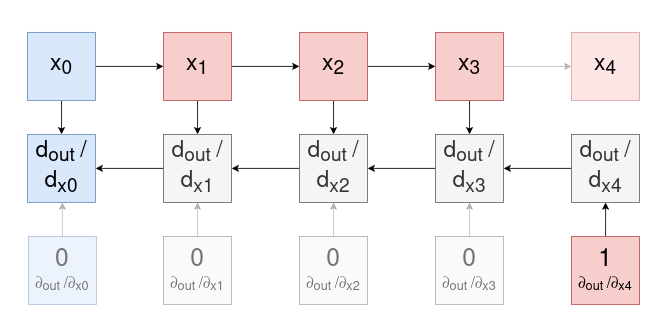

Where at each intermediate step we accumulate the total gradient coming from the next step (the horizontal ← arrow), which represents the effect this variable had in the subsequent iterations of the loop, and the partial gradient coming from it's direct use (the vertical ↑ arrow).

It just so happened that in the first derivative example, the only "external" gradient contribution was at the very last step (`dout_dx4 = 1.0`).

Now we have the reversed scenario. All but the last step have external contributions, the partial second derivatives with respect to each intermediate `x` of the original forward loop.

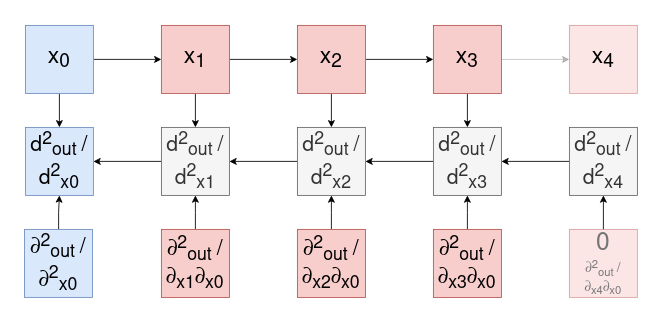

In [16]:
dout_dx = [dout_dy3, dout_dy2, dout_dy1, dout_dy0, 0]
for i in reversed(range(4)):
    dout_dx[i] += float(d_step_fn(xs[i], dout_dx[i+1]))
dout_dx0 = dout_dx[0]
dout_dx0

117.04199498772715

This value we can check easily against the symbolic second derivative

In [17]:
16 * 15 * x0 ** 14

117.0419949877271

### General strategy: A tape to accumulate partial derivatives as we iterate

Maintaining a read/write tape of accumulated partials per step is the core of loop autodiff in PyTensor.

We can represent the first gradient loop with the same general approach. This time let's be smart and remember to store the intermediate values.

In [18]:
dout_dx = [0, 0, 0, 0, 1]
for i in reversed(range(4)):
    dout_dx[i] += float(d_step_fn(xs[i], dout_dx[i+1]))
dout_dx0 = dout_dx[0]
dout_dx0

7.412659682556052

It can also be used for the second gradient loop. In our quick and dirty implementation above we computed 2 intermediate quantities separately `dout_dyt` and `dzt_dztm1`, and then combined them manually like this:

In [19]:
dout_dy3 = dout_dz4 * dz4_dy3
dout_dy2 = dout_dz4 * dz4_dz3 * dz3_dy2
dout_dy1 = dout_dz4 * dz4_dz3 * dz3_dz2 * dz2_dy1
dout_dy0 = dout_dz4 * dz4_dz3 * dz3_dz2 * dz2_dz1 * dz1_dy0
(dout_dy3, dout_dy2, dout_dy1, dout_dy0)

(7.802799665848476, 8.21347333247208, 9.100801476423358, 11.1733967375)

Now we'll do it all in a single pass, using our autodiff machinery

In [20]:
ztm1 = pt.scalar("ztm1")
ytm1 = pt.scalar("ytm1")

zt = 2 * ytm1 * ztm1

dout_dzt = pt.scalar("dout_dzt")
dout_dztm1 = pytensor.gradient.Lop(zt, wrt=ztm1, eval_points=dout_dzt)
dout_dytm1 = pytensor.gradient.Lop(zt, wrt=ytm1, eval_points=dout_dzt)

d_dzt_step_fn = pytensor.function([ytm1, dout_dzt], dout_dztm1)
d_dyt_step_fn = pytensor.function([ztm1, dout_dzt], dout_dytm1)

In [21]:
# Inputs to our loop
# z: the reversed forward steps consumed by the first auto-diff loop (reversed once more)
z = y[::-1]
# w: the intermediate steps produced by the first auto-diff loop (already reversed,
# ignoring the last entry which isn't needed)
w = dout_dx[1:]
# partial derivatives of each intermediate step of the second auto-diff loop,
# only first variable is connected to the cost
dout_dzt = [1, 0, 0, 0, 0]
# partial derivatives of the second auto-diff loop with respect to each read sequence
dout_dyt = []
for i in range(4):
    # Accumulate the partial derivative with respect to the previous step
    dout_dzt[i+1] = float(d_dzt_step_fn(z[i], dout_dzt[i]))
    # Output the partial derivative with respect to the read sequence
    dout_dyt.append(float(d_dyt_step_fn(w[i], dout_dzt[i])))
dout_dyt
[7.802799665848476, 8.21347333247208, 9.100801476423358, 11.1733967375]

[7.802799665848476, 8.21347333247208, 9.100801476423358, 11.1733967375]

Although not always needed, this approach is the most general. We've seen how it can be used to accumulate gradients where only the last state of the loop is connected to the cost, or where all but the last state are connected. In fact, we can have arbitrary dense/sparse/uneven connection between intermediate steps and the final function cost.

The only thing we haven't discussed is how to explicitly differentiate over the operation of updating such a tape. We won't show it here, but the same tape procedure can be used for it, meaning we have a closed auto-diff system (i.e., we can keep doing higher order differentiation using the exesting procedures)

## PyTensor Scan

PyTensor uses Scan to represent symbolic loops. For reasons that are now clear, it automatically stores a tape of initial, intermediate results, and final results as iterates. It masks the initial results before returning the sequence.

When a user is only interested in the final element (or any subset), they should index the returned sequence. Differentiating through this indexing operation creates a mask of zeros for the unused values, and the gradient for used ones. This is the very tape that will be updated by the reverse Scan.

Use `dprint` on the function below to identify these elements and the four `Scan` instances derived in the notebook.

In [22]:
x0 = pt.scalar("x0")
xs, _ = pytensor.scan(
    fn = lambda xtm1: xtm1 ** 2,
    outputs_info=[x0],
    n_steps=4,
    # for readability
    mode=get_default_mode().excluding("fusion")
)
out = xs[-1]
g = pt.grad(out, wrt=x0)
h = pt.grad(g, wrt=x0)

# for readability
mode = get_default_mode().excluding("scan_pushout")
h_fn = pytensor.function([x0], h, mode=mode)
# Uncomment line below
# h_fn.dprint(print_shape=True)